In [1]:
%matplotlib notebook

import numpy as np
import scipy as sc
import scipy.linalg as la
import scipy.sparse.linalg as sp


from imageio import imread
from matplotlib import pyplot as plt

In [2]:
def laplacian(A):
    '''This function computes for the laplacian L = D - A where D is the degree matrix and A is the adjacency matrix.'''
    D = np.diag([sum(A[i]) for i in range(0, A.shape[0])])
    return D - A

In [3]:
# Sanity check

A = np.array([[0,1,0,0,1,1],
              [1,0,1,0,1,0],
              [0,1,0,1,0,0],
              [0,0,1,0,1,1],
              [1,1,0,1,0,0],
              [1,0,0,1,0,0]])

laplacian(A)

array([[ 3, -1,  0,  0, -1, -1],
       [-1,  3, -1,  0, -1,  0],
       [ 0, -1,  2, -1,  0,  0],
       [ 0,  0, -1,  3, -1, -1],
       [-1, -1,  0, -1,  3,  0],
       [-1,  0,  0, -1,  0,  2]])

In [4]:
def prob2(A, tol=10e-5):
    # Computes for the laplacian of the adjacency matrix A
    L = laplacian(A)

    # Computes the eigenvalues of L. The eigenvalues list is then sorted from least to greatest
    eigs = np.array([i.real for i in la.eigvals(L)])

    # Number of components
    eigs[eigs<tol] = 0      #If element in eigs is less than tols, set it to zero
    num_connected = len(eigs)

    # Algebraic connectivity
    unique_eigs = np.unique(eigs)
    unique_eigs.sort
    alg_connectivity = unique_eigs[1]
    
    return num_connected, alg_connectivity

In [5]:
# G1
A = np.array([[0,1,0,0,1,1],
              [1,0,1,0,1,0],
              [0,1,0,1,0,0],
              [0,0,1,0,1,1],
              [1,1,0,1,0,0],
              [1,0,0,1,0,0]])

prob2(A)

(6, 1.5857864376269044)

In [6]:
# G2
A = np.array([[0, 3, 0, 0, 0, 0],
              [3, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 1, 0, 2,.5],
              [0, 0, 0, 2, 0, 1],
              [0, 0, 0,.5, 1, 0]])

prob2(A)

(6, 1.0000000000000002)

# Image Segmenter

In [7]:
image = imread("dream.png")
image.shape

(48, 48, 3)

In [8]:
scaled = image/255

<IPython.core.display.Javascript object>


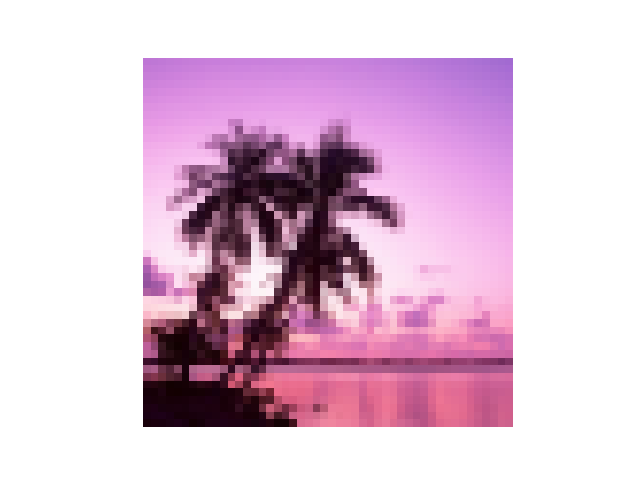

(-0.5, 47.5, 47.5, -0.5)

In [9]:
plt.figure()
plt.imshow(scaled)
plt.axis("off")

### Brightness image (grayscale)

<IPython.core.display.Javascript object>


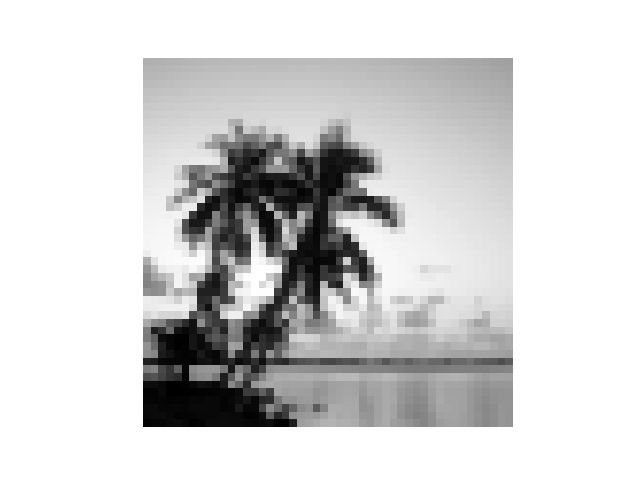

(-0.5, 47.5, 47.5, -0.5)

In [10]:
brightness = scaled.mean(axis=2)

plt.figure()
plt.imshow(brightness, cmap='gray')
plt.axis("off")

# Image segmentation Constructor 

In [11]:
class ImageSegmenter:
    '''
    1. Accepts the name of an image
    2. Read the image, and scale
    3. If the image is in color, compute the brightness matrix
    4. Flatten the brightness matrix into a 1-D array which will be stored as an attribute
    '''
    
    def __init__(self, img_name):
        # Read the image and convert it into a matrix
        self.image = imread(img_name)
        
        # Scales the image
        self.scaled = self.image/255
        
        # If image is colored make it into a scaled grayscale image
        if self.image.shape[-1]==3:
            self.brightness = self.scaled.mean(axis=2)
            
            # Dimensions of the brightness matrix
            self.m, self.n = self.brightness.shape
            self.mn = self.m* self.n
            
            brightness = np.ravel(self.brightness)
            
        # If image is black and white already, ravel the matrix
        else:
            # Dimensions of the brightness matrix
            self.m, self.n = brightness.shape
            self.mn = m*n
            brightness = np.ravel(scaled)


        # Flat brightness
        self.B = np.ravel(brightness)
            
            
            
    # METHODS        
    def show_original(self):
        plt.figure()
    
        # Colored
        if image.shape[-1]==3:
            plt.imshow(self.image)
            
        # Grayscale
        else:
            plt.imshow(self.image, cmap="gray")
            
        plt.axis("off")
        
        
        
    def segmenter(self, r=5, sigma_2_B=.02, sigma_2_X=3):
        ''' Write a method for the ImageSegmenter class that accepts floats r defaulting to
            5, σB2 defaulting to :02, and σX2 defaulting to 3. Compute the adjacency matrix A and the
            degree matrix D according to the weights'''
        
        def get_neighbors(index, radius, height, width):
            """Calculate the flattened indices of the pixels that are within the given
            distance of a central pixel, and their distances from the central pixel.
            Parameters:
            index (int): The index of a central pixel in a flattened image array
            with original shape (radius, height).
            radius (float): Radius of the neighborhood around the central pixel.
            height (int): The height of the original image in pixels.
            width (int): The width of the original image in pixels.
            Returns:
            (1-D ndarray): the indices of the pixels that are within the specified
            radius of the central pixel, with respect to the flattened image.
            (1-D ndarray): the euclidean distances from the neighborhood pixels to
            the central pixel.
            """
            # Calculate the original 2-D coordinates of the central pixel.
            row, col = index // width, index % width
            # Get a grid of possible candidates that are close to the central pixel.
            r = int(radius)
            x = np.arange(max(col - r, 0), min(col + r + 1, width))
            y = np.arange(max(row - r, 0), min(row + r + 1, height))
            X, Y = np.meshgrid(x, y)

            # Determine which candidates are within the given radius of the pixel.
            R = np.sqrt(((X - col)**2 + (Y - row)**2))
            mask = R < radius
    
            return (X[mask] + Y[mask]*width).astype(np.int), R[mask]
        
        
        mn = self.mn
        m, n = self.m, self.n
        
        # Blank adjacency matrix composed of zeros
        A = np.zeros((mn, mn))#sc.sparse.lil_matrix((mn,mn)) #np.zeros((mn, mn)) # 2304 x 2304
        self.D = np.zeros(mn)
        
        B = self.B
            
        for i in range(0, mn):
            '''Computes for A and D'''

            # J contains pixel indices within r, Euclidian distance, X, of each pixel index to the other pixels within r
            J, X = get_neighbors(i, r, m, n)

            # Calculates the weights
            for j,k in zip(J, range(0, len(J))):
                A[i][j] = np.exp(- (abs(B[i] - B[j]) / sigma_2_B) - (X[k] / sigma_2_X) )

            # Computing for D
            self.D[i] = sum([A[i][k] for k in J])
                    
            # Computing for D
            self.D[i] = sum([A[i][k] for k in J])
            
        self.A = sc.sparse.csc_matrix(A)
        return self.A, self.D
    
    
    def mask(self, A, D):
        D_1_2 = [1/np.sqrt(i) for i in D]
        D_1_2 = sc.sparse.diags(D_1_2) # Converting to diagonal

        #Compute the laplacian
        L = sc.sparse.csgraph.laplacian(A)

        DLD = D_1_2 @ L @ D_1_2

        # Finding the second smallest eigenvalue
        eigvalue, eig_vector = sp.eigsh(DLD, which="SM", k=2)
        
        # Eigenvector of the second smallest eigenvalue
        self.eig_vector = eig_vector[:,1].reshape(self.m,self.n)
        return self.eig_vector
    
    
    
    def plotter(self, eig_vector):
        mask = eig_vector > 0
        neg_mask = ~mask
        
        # if Image is colored
        if image.shape[-1]==3:
            plt.figure()
            plt.subplot(1,3,1)
            plt.imshow(self.scaled)
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.imshow(self.scaled * np.dstack((mask, mask,mask)), label="Positive Cut")
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(self.scaled * np.dstack((neg_mask, neg_mask, neg_mask)), label="Negative Cut")
            plt.axis('off')

            plt.suptitle("(a) Original Image, (b) Positive Segment, (c) Negative Segment", x=0.51, y = 0.8)
            
            
        # if Image is grayscale
        else:
            plt.figure()
            plt.subplot(1,3,1)
            plt.imshow(self.scaled, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.imshow(self.scaled * mask, cmap='gray', label="Positive Cut")
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(self.scaled * neg_mask, cmap='gray', label="Negative Cut")
            plt.axis('off')

            plt.suptitle("(a) Original Image, (b) Positive Segment, (c) Negative Segment", x=0.51, y = 0.8)

<IPython.core.display.Javascript object>


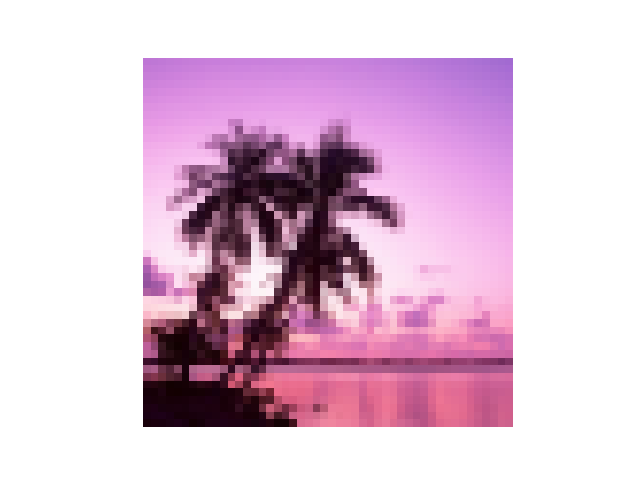

In [12]:
x = ImageSegmenter("dream.png")
x.show_original()

<IPython.core.display.Javascript object>


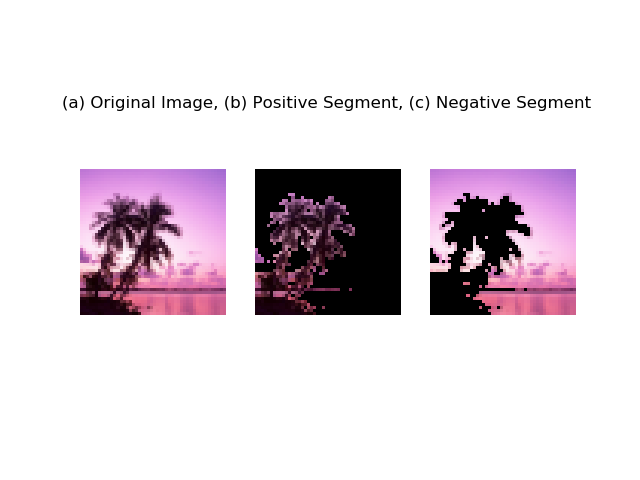

In [13]:
A, D = x.segmenter()
x.plotter(x.mask(A, D))